In [1]:
import pandas as pd
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [2]:
dataset = pd.read_csv('database/steam.csv', header=None)

dataset.head() 
# dataset.info()

,0,1,2,3,4
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [3]:
dataset.columns = ['user_id', 'game_title', 'purchase_status', 'hours_played','0']
dataset.head()

,user_id,game_title,purchase_status,hours_played,0
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


<Axes: >

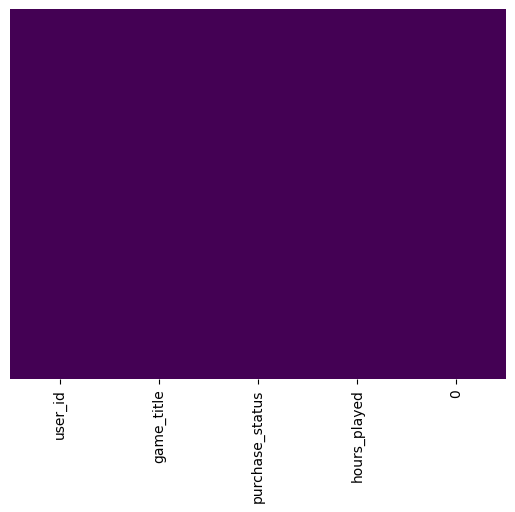

In [4]:
sns.heatmap(dataset.isnull(), yticklabels=False, cbar=False, cmap= 'viridis')

In [5]:
# Separate purchase and play data
purchase_data = dataset[dataset['purchase_status'] == 'purchase']
play_data = dataset[dataset['purchase_status'] == 'play']

# Merge purchase and play data on user_id and game_title
merged_data = pd.merge(
    purchase_data[['user_id', 'game_title', 'hours_played']],  # Only need purchase records
    play_data[['user_id', 'game_title', 'hours_played']],
    on=['user_id', 'game_title'],
    how='left',
    suffixes=('_purchase', '_play')  # Differentiate columns
)

# Determine actual hours played (default to 1 if no play data exists)
merged_data['actual_hours_played'] = merged_data['hours_played_play'].fillna(1.0)

# Create the interaction matrix
interaction_matrix = merged_data.pivot_table(
    index='user_id',
    columns='game_title',
    values='actual_hours_played',
    fill_value=0  # Fill missing values with 0 (indicating no play or purchase)
)

# Display the shape and a sample of the interaction matrix
interaction_matrix.shape, interaction_matrix.head()


((12393, 5155),
 game_title  007 Legends  0RBITALIS  \
 user_id                              
 5250                0.0        0.0   
 76767               0.0        0.0   
 86540               0.0        0.0   
 103360              0.0        0.0   
 144736              0.0        0.0   
 
 game_title  1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby)  \
 user_id                                                                  
 5250                                                      0.0            
 76767                                                     0.0            
 86540                                                     0.0            
 103360                                                    0.0            
 144736                                                    0.0            
 
 game_title  10 Second Ninja  10,000,000  100% Orange Juice  1000 Amps  \
 user_id                                                                 
 5250                    0.0      

In [6]:
game_similarity = cosine_similarity(interaction_matrix.T)  
game_similarity_df = pd.DataFrame(
    game_similarity, 
    index=interaction_matrix.columns, 
    columns=interaction_matrix.columns
)

In [7]:
def recommender(user_id, interaction_matrix, similarity_matrix, top_n=5):
    user_play_history = interaction_matrix.loc[user_id]
    
    played_games = user_play_history[user_play_history > 0].index
    scores = similarity_matrix.loc[played_games].sum(axis=0) #unplayed games
    
    scores = scores.drop(played_games)
    return scores.nlargest(top_n)

In [11]:
user_id = interaction_matrix.index[34] #index 0 to 12393
recommendations = recommender(user_id, interaction_matrix, game_similarity_df)
print(f"Top recommendations for user {user_id}:\n", recommendations)

Top recommendations for user 1268792:
 game_title
Sniper Elite                   1.911481
War Inc. Battlezone            1.819680
Half-Life Deathmatch Source    1.760545
Half-Life 2 Lost Coast         1.535737
Half-Life 2 Episode Two        1.309461
dtype: float64
